In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

warnings.simplefilter("ignore")
%matplotlib inline
sns.set(style="darkgrid")

#  Разведочный анализ данных

Посмотрим на имеющиеся данные

In [ ]:
data = pd.read_csv("weather.csv")
data.head(6)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No


Смотрим на количество объектов, их признаков

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     142193 non-null  int64  
 1   Date           142193 non-null  object 
 2   Location       142193 non-null  object 
 3   MinTemp        141556 non-null  float64
 4   MaxTemp        141871 non-null  float64
 5   Rainfall       140787 non-null  float64
 6   Evaporation    81350 non-null   float64
 7   Sunshine       74377 non-null   float64
 8   WindGustDir    132863 non-null  object 
 9   WindGustSpeed  132923 non-null  float64
 10  WindDir9am     132180 non-null  object 
 11  WindDir3pm     138415 non-null  object 
 12  WindSpeed9am   140845 non-null  float64
 13  WindSpeed3pm   139563 non-null  float64
 14  Humidity9am    140419 non-null  float64
 15  Humidity3pm    138583 non-null  float64
 16  Pressure9am    128179 non-null  float64
 17  Pressure3pm    128212 non-nul

Целевая переменная --- наличие дождя завтра

Видно, что большинство признаков вещественные, но есть несколько категориальных:
*   Дата --- Date
*   Локация --- Location
*   Направление ветра в 9:00 --- WindDir9am
*   Направление ветра в 15:00 --- WindDir3pm
*   направление самого сильного порыва ветра за последние 24 часа --- WindGustDir
*   Наличие дождя сегодня

Можем сразу убрать из датасета не несущую смысловой нагрузки информацию

In [ ]:
del data['Unnamed: 0']
data =data.replace({'RainTomorrow': {'Yes': 1, 'No': 0}})

Посмотрим на средние показатели числовых признаков в случае когда дождь есть и когда его нет.

In [ ]:
data.groupby('RainTomorrow').mean()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
RainTomorrow,,,,,,,,,,,,,,,,
0,11.897675,23.836247,1.270290,5.734807,8.546358,38.288391,13.567314,18.222804,66.217573,46.510625,1018.595599,1016.113587,3.932282,3.921896,17.077001,22.402905
1,13.186890,21.119100,6.142104,4.527779,4.471761,45.946764,15.508577,20.078509,77.983314,68.800019,1014.400000,1012.300820,6.099990,6.360065,16.676598,19.197113


Можно сделать несколько выводов.
В случае когда на следующий день дождь пошел:

*   Среднее количество осадков, зафиксированных за день в мм (Rainfall) больше
*   Число солнечных часов за день (Sunshine) меньше
*   Порывы ветра (WindGustSpeed и WindSpeed) сильней
*   Cloud больше
*   Влажность (Humidity) больше



Можно отдельно посмотреть на признак RainToday. Видно, что завтра дождь будет будет более вероятней (в 3 раза), если он шел сегодня

In [ ]:
data.groupby('RainToday')['RainTomorrow'].mean()

RainToday
No     0.151868
Yes    0.464060
Name: RainTomorrow, dtype: float64

Text(0, 0.5, 'RainTomorrow')

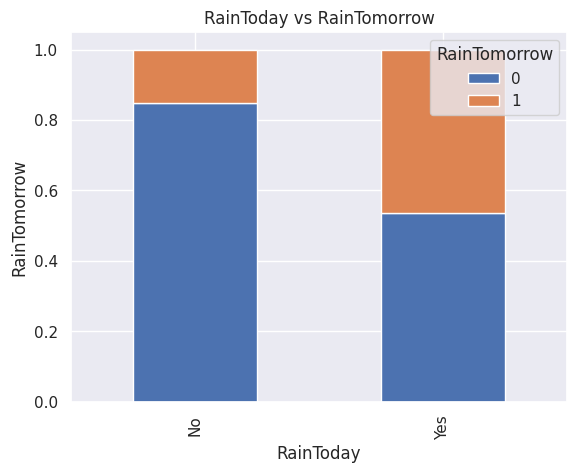

In [ ]:
table=pd.crosstab(data["RainToday"],data["RainTomorrow"])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('RainToday vs RainTomorrow')
plt.xlabel('RainToday')
plt.ylabel('RainTomorrow')

Делим датасет на train и test

In [ ]:
y = data['RainTomorrow']
X = data.drop(columns=['RainTomorrow'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)
print('Размер тестовой выборки', y_test.shape[0])

Размер тестовой выборки 35549


Посмотрим как часто в целом идет дождь

<Axes: title={'center': 'test'}, ylabel='RainTomorrow'>

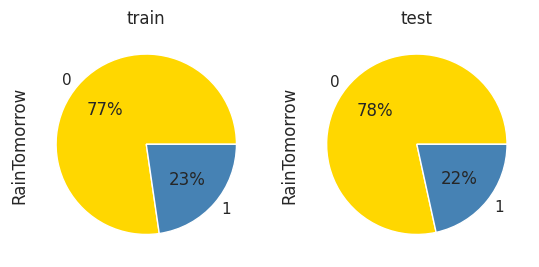

In [ ]:
plt.subplot(1, 2, 1)
plt.title('train')
y_train.value_counts().plot(kind='pie',autopct='%1.0f%%', colors = ['gold', 'steelblue'])

plt.subplot(1, 2, 2)
plt.title('test')
y_test.value_counts().plot(kind='pie',autopct='%1.0f%%', colors = ['gold', 'steelblue'])

Полезно посмотреть для каких признаков больше всего пропусков

In [ ]:
data.isna().mean().sort_values(ascending = False)

Sunshine         0.476929
Evaporation      0.427890
Cloud3pm         0.401525
Cloud9am         0.377353
Pressure9am      0.098556
Pressure3pm      0.098324
WindDir9am       0.070418
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir3pm       0.026570
Humidity3pm      0.025388
Temp3pm          0.019171
WindSpeed3pm     0.018496
Humidity9am      0.012476
Rainfall         0.009888
RainToday        0.009888
WindSpeed9am     0.009480
Temp9am          0.006358
MinTemp          0.004480
MaxTemp          0.002265
Date             0.000000
Location         0.000000
RainTomorrow     0.000000
dtype: float64

# Логистическая регрессия и генерация признаков

Пока учтем только числовые признаки, а пропуски заменим средним значением. В качестве оценки качества кажется логичным будет смотреть на recall. Лучше будет ошибиться, сказав что дождь пойдет (человек возьмет зонт, который ему не пригодится), чем ошибиться, сказав что его не будет (человек промокнет, простудится)

In [ ]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

Константная модель дает неплохой accuracy за счет дисбаланса классов, но recall положительного класса нулевой, т.е. мы абсолютно не предсказываем дожди

In [ ]:
best_constant = y_train.median()
print(classification_report(y_test, best_constant * np.ones(y_test.shape)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     27882
           1       0.00      0.00      0.00      7667

    accuracy                           0.78     35549
   macro avg       0.39      0.50      0.44     35549
weighted avg       0.62      0.78      0.69     35549



In [ ]:
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     31706
           1       0.39      0.78      0.52      3843

    accuracy                           0.84     35549
   macro avg       0.68      0.82      0.71     35549
weighted avg       0.91      0.84      0.87     35549



Посмотрим на полученные веса и масштабы признаков

In [ ]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Deviation")
    plt.tight_layout()

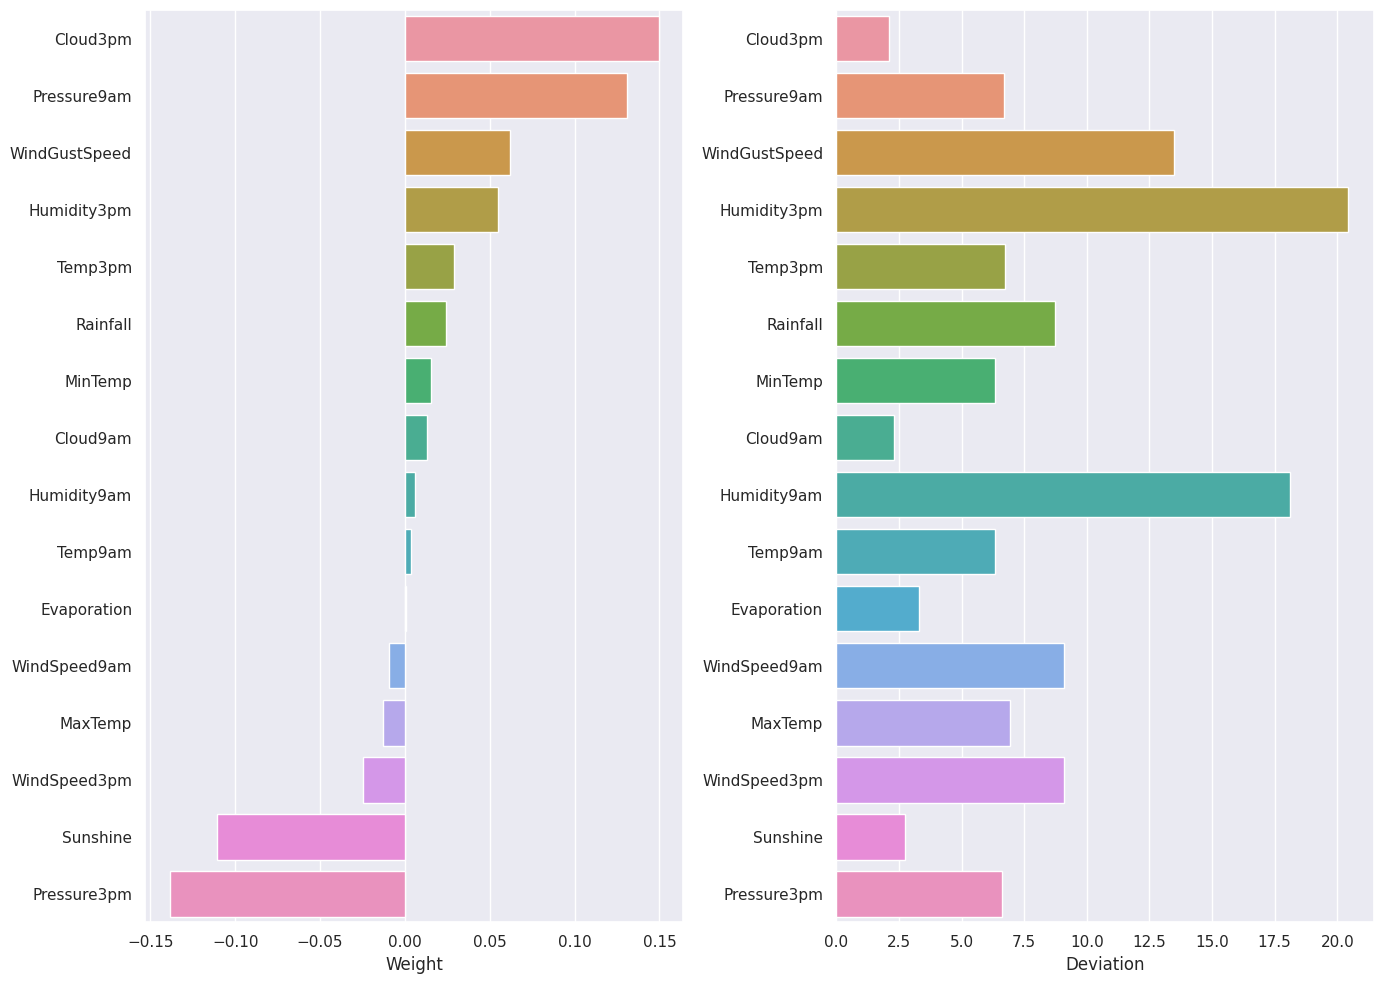

In [ ]:
show_weights(numeric_features, model.coef_[0], X_train[numeric_features].std())

Для того чтобы судить о значимости признаков проведем масштабирование (E = 0, D = 1)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

Качество после масштабирования не выросло. Посмотрим на коэффициенты

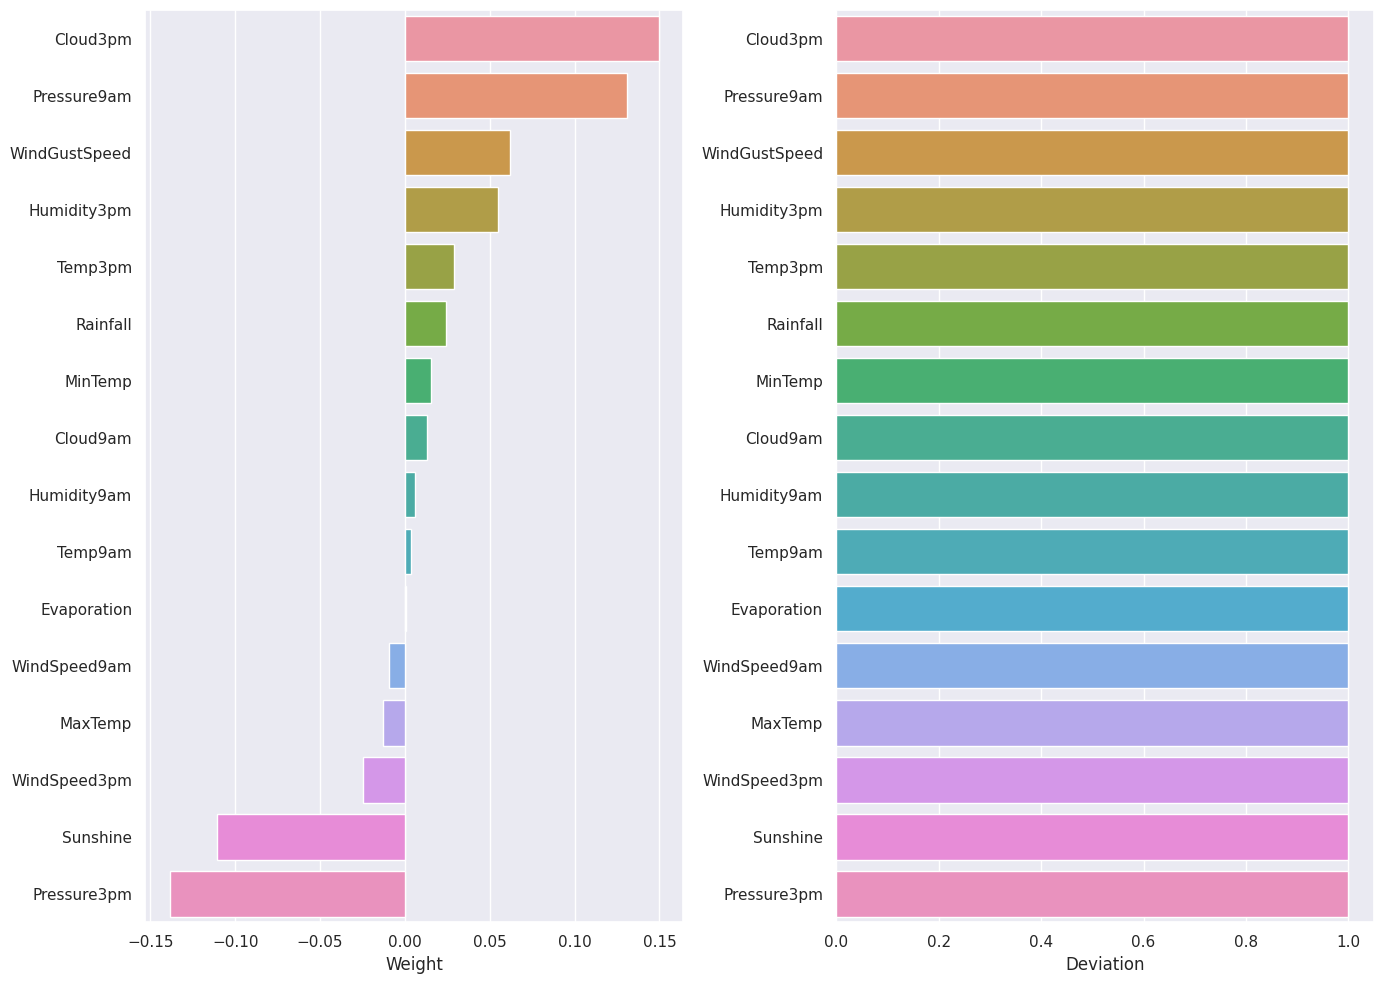

In [ ]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_[0], scales)

Можно заметить что для парных признаков, веса, соответствующие 3pm имеют большее по модулю значение, чем зафикисрованные в 9am. Это можно объяснить тем что 3pm более близкое время к завтрашнему дню, т.е. более актуальное. Можем попробовать убрать признаки Cloud9am, Evaropation Temp9am. Значительного изменения результата это не вызвало

In [ ]:
numeric_features_2 = numeric_features.drop(['WindSpeed9am', 'Cloud9am','Evaporation','Temp9am','Humidity9am'])
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train[numeric_features_2], y_train)

y_pred = model.predict(X_test[numeric_features_2])
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     31738
           1       0.39      0.78      0.52      3811

    accuracy                           0.84     35549
   macro avg       0.68      0.82      0.71     35549
weighted avg       0.91      0.84      0.87     35549



Добавим категориальные признаки

In [ ]:
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")
print(X_test[categorical_features].head(5))

              Date Location WindGustDir WindDir9am WindDir3pm RainToday
106644  2010-10-08   Albany    NotGiven        NNE         SE        No
106645  2010-10-09   Albany    NotGiven         SW        WSW        No
106646  2010-10-10   Albany    NotGiven        WSW         SW        No
106647  2010-10-11   Albany    NotGiven        WSW         SW       Yes
106648  2010-10-12   Albany    NotGiven         SE          S        No


In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features_2)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('Regression', LogisticRegression(solver = 'sag'))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     30501
           1       0.47      0.72      0.57      5048

    accuracy                           0.85     35549
   macro avg       0.71      0.79      0.74     35549
weighted avg       0.88      0.85      0.86     35549



Модель стала работать дольше и хуже. Это может быть связано с тем что признаков стало очень много (в том числе очень много уникальных дат (3436 уникальных даты)

In [ ]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (106644, 22)
Size after OneHot: (106644, 3540)


In [ ]:
X_train[categorical_features].describe()

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
count,106644,106644,106644,106644,106644,106644
unique,3436,37,17,17,17,3
top,2013-12-01,Canberra,W,N,W,No
freq,36,3418,8335,8898,7765,81642


Сгруппируем даты в более общие категории, например, будем учитывать только месяц

In [ ]:
data_months = data.copy(deep = True)
data_months["Date"] = data_months["Date"].astype("datetime64[ns]")
data_months["Date"] = data_months["Date"].dt.month.astype("object")
y = data_months['RainTomorrow']
X = data_months.drop(columns=['RainTomorrow'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)

Посмотрим на средние характеристики признаков для каждого месяца. Можно заметить, что средняя температура сначала убывает от 1-го месяца до 7-го, а потом возрастает до 12-го. Можно сделать вывод, что разделение на месяцы существенно

In [ ]:
X_train.groupby('Date').mean()[['MinTemp','MaxTemp','Sunshine']]

,MinTemp,MaxTemp,Sunshine
Date,,,
1,17.468853,29.362063,9.103043
2,17.470432,28.585598,8.346940
3,15.759461,26.431830,7.392479
4,12.556532,22.979148,6.878353
5,9.319904,19.427457,6.053542
6,7.475814,16.591971,5.281612
7,6.664549,16.088697,5.780810
8,7.080394,17.585502,6.946933
9,9.178030,20.314214,7.518817


Можно посмотреть распределение минимальной температуры для 3-го и 4-го месяцев

<Axes: xlabel='MinTemp', ylabel='Density'>

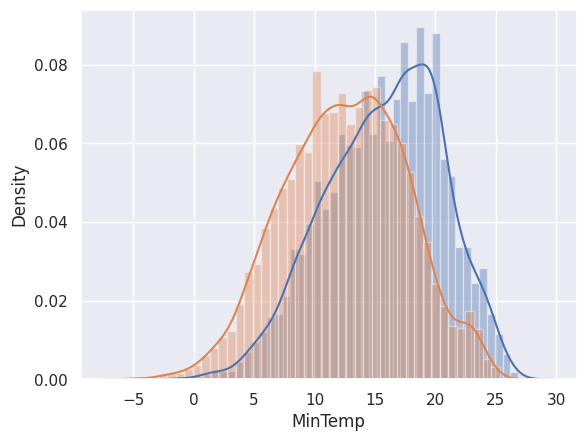

In [ ]:
sns.distplot(X_train[X_train['Date'] == 3]["MinTemp"])
sns.distplot(X_train[X_train['Date'] == 4]["MinTemp"])

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(solver = 'sag'))]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     31583
           1       0.40      0.78      0.53      3966

    accuracy                           0.85     35549
   macro avg       0.68      0.82      0.72     35549
weighted avg       0.90      0.85      0.87     35549



Качество модели улучшилось. Сгруппируем признаки, связанные с направлением ветра. Посмотрим на средние значения показателей. Можно проследить, что, например, для направлений E, ENE, ESE показатели достаточно близки (по сравнению например с W, WNW, WSW). Возникает логичная идея сгруппировать признаки по первой букве направления для сокращения числа признаков

In [ ]:
data.groupby("WindDir9am").mean()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
WindDir9am,,,,,,,,,,,,,,,,,
E,13.217264,26.176231,1.426456,6.493581,8.945807,37.848551,14.994459,16.848894,62.808955,43.947529,1018.848837,1015.623387,3.663448,3.809074,18.780051,24.798372,0.145723
ENE,13.187448,26.381408,1.440193,6.327690,8.804018,37.650992,14.044732,16.474259,63.585509,44.359011,1018.383826,1015.081089,3.640424,3.962805,18.938122,24.932096,0.176471
ESE,13.626999,25.653523,1.804961,6.604857,8.627538,38.396691,14.662874,17.945899,63.287605,46.332516,1018.759172,1015.800127,3.946166,3.942899,18.868057,24.161910,0.147923
N,11.579480,23.474053,1.481404,5.159229,6.835224,45.395245,16.430703,21.242416,66.904851,50.829783,1016.027694,1013.047932,4.650946,5.055747,16.923274,21.756045,0.308084
NE,12.999094,26.012770,1.567206,5.781249,8.033878,38.102968,12.706257,16.735938,64.795253,46.006958,1017.831422,1014.534859,3.977405,4.371644,18.814002,24.451736,0.208317
NNE,12.706967,25.422176,1.287470,5.758020,7.505035,41.468778,14.528938,19.006193,65.102561,47.792395,1016.882100,1013.571847,4.257036,4.650108,18.384323,23.800444,0.268873
NNW,11.048767,21.794205,2.238589,4.370845,6.846496,43.938696,14.439668,20.363286,70.478563,54.892318,1014.942869,1012.479491,4.766004,5.066637,15.909590,20.003206,0.309949
NW,11.153938,21.704072,2.440432,4.511697,7.158253,43.001462,14.180893,20.015879,70.554545,54.497127,1015.595403,1013.325148,4.310406,4.563354,15.970632,19.926608,0.279350
S,13.509610,23.048398,3.312773,5.995285,7.330995,39.743281,15.594136,19.762867,70.492774,54.140827,1018.368299,1016.622765,4.834972,4.477088,17.569992,21.545576,0.197928


In [ ]:
X_train["WindGustDir"].unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', 'NotGiven', 'E', 'SSW'], dtype=object)

In [ ]:
data_wind = data_months.copy(deep=True)

data_wind.loc[data_wind["WindGustDir"].isin(["WNW","WSW"]), "WindGustDir"] = "W"
data_wind.loc[data_wind["WindGustDir"].isin(["NE","NNW","NNE", "NW"]), "WindGustDir"] = "N"
data_wind.loc[data_wind["WindGustDir"].isin(["SW","SSE","SE", "SSW"]), "WindGustDir"] = "S"
data_wind.loc[data_wind["WindGustDir"].isin(["ENE","ESE","SE", "SSW"]), "WindGustDir"] = "E"

data_wind.loc[data_wind["WindDir9am"].isin(["WNW","WSW"]), "WindDir9am"] = "W"
data_wind.loc[data_wind["WindDir9am"].isin(["NE","NNW","NNE", "NW"]), "WindDir9am"] = "N"
data_wind.loc[data_wind["WindDir9am"].isin(["SW","SSE","SE", "SSW"]), "WindDir9am"] = "S"
data_wind.loc[data_wind["WindDir9am"].isin(["ENE","ESE","SE", "SSW"]), "WindDir9am"] = "E"

data_wind.loc[data_wind["WindDir3pm"].isin(["WNW","WSW"]), "WindDir3pm"] = "W"
data_wind.loc[data_wind["WindDir3pm"].isin(["NE","NNW","NNE", "NW"]), "WindDir3pm"] = "N"
data_wind.loc[data_wind["WindDir3pm"].isin(["SW","SSE","SE", "SSW"]), "WindDir3pm"] = "S"
data_wind.loc[data_wind["WindDir3pm"].isin(["ENE","ESE","SE", "SSW"]), "WindDir3pm"] = "E"

y = data_wind['RainTomorrow']
X = data_wind.drop(columns=['RainTomorrow'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)

X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

In [ ]:
X_train["WindGustDir"].unique()

array(['W', 'N', 'S', 'E', 'NotGiven'], dtype=object)

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]
)

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     31649
           1       0.40      0.78      0.53      3900

    accuracy                           0.85     35549
   macro avg       0.68      0.82      0.72     35549
weighted avg       0.91      0.85      0.87     35549



Качество модели чуть улучшилось. Попробуем разобраться с Location. Если сгруппировать данные по локациям и посмотреть на частотность дождя, то можно сделать вывод, что локация влияет на таргет, то есть в каких-то локациях дождь идет чаще чем в других (частотность от 6 до 36 процентов)

In [ ]:
train_data = data.loc[list(range(1,data.shape[0]*3//4))]
train_data.groupby('Location')['RainTomorrow'].mean().sort_values()

Location
Woomera             0.067559
Mildura             0.108746
Cobar               0.129183
Moree               0.138052
Nhil                0.154238
Townsville          0.171118
WaggaWagga          0.180108
Canberra            0.184026
Bendigo             0.185234
Tuggeranong         0.189460
Richmond            0.189766
Nuriootpa           0.197202
BadgerysCreek       0.199112
Penrith             0.200742
Albury              0.205316
Sale                0.214333
MelbourneAirport    0.217016
Adelaide            0.222654
Brisbane            0.224296
Wollongong          0.239021
Watsonia            0.246082
Newcastle           0.247377
SydneyAirport       0.257571
Ballarat            0.257926
Sydney              0.259215
GoldCoast           0.260067
Melbourne           0.261191
Williamtown         0.274187
NorahHead           0.275862
Albany              0.279586
MountGinini         0.281734
CoffsHarbour        0.294277
MountGambier        0.303630
NorfolkIsland       0.310054
Dartm

К сожалению, в датасете объекты отсортированы по локациям. В условии дз требовалось не перемешивать данные при отборе трейна и теста, поэтому в тест попадут те локации, которых не было на трейне. Поэтому мне кажется, что признак Location следует убрать, хоть он и влияет на таргет. Попробуем добавить selector для отбора признаков

In [ ]:

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]
)

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
categorical_features.remove('Location')
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.97      0.85      0.91     31629
           1       0.40      0.78      0.53      3920

    accuracy                           0.85     35549
   macro avg       0.68      0.82      0.72     35549
weighted avg       0.91      0.85      0.87     35549



In [ ]:
%%timeit
clf.fit(X_train, y_train)

1.08 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Подберем гиперпараметры по сетке

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "preprocessor__cat__selector__percentile": [10, 20, 30],
    "classifier__C": [1, 10, 100, 200],
}

search_cv = GridSearchCV(clf, param_grid, scoring= 'recall')
search_cv.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
       'WindSpeed3pm', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm',
       'Temp3pm'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(h...
                                                                                         ('selector',
                                                                                          SelectPercentile(percentile=50,
                                                                                                           score_func=<function chi2 at 0x7f0b3ac64940>))]),
                                                                         ['WindGustDir',
                                                                          'WindDir9am',
                                                                          'WindDir3pm',
                                                                          'RainToday'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [1, 10, 100, 200],
                         'preprocessor__cat__selector__percentile': [10, 20,
                                                                     30],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='recall')

In [ ]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'classifier__C': 100, 'preprocessor__cat__selector__percentile': 30, 'preprocessor__num__imputer__strategy': 'median'}


In [ ]:
y_pred = search_cv.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     31716
           1       0.39      0.79      0.52      3833

    accuracy                           0.85     35549
   macro avg       0.68      0.82      0.72     35549
weighted avg       0.91      0.85      0.87     35549



Можно заметить, что для подавляющего большинства объектов количество осадков, зафиксированных за день, меньше 40 мм. Но в отдельные дни количество осадков намного больше, вплоть до 370 мм

<Axes: ylabel='Frequency'>

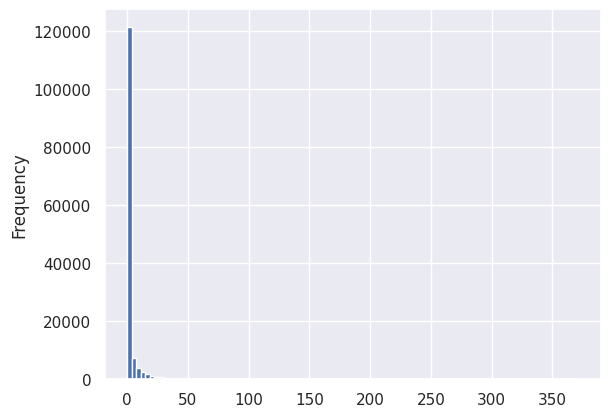

In [ ]:
data["Rainfall"].plot(kind='hist', bins = 100)

In [ ]:
value = 200
rainfall = data[data["Rainfall"] > value].size / data.size * 100
print(f'Дней в которые выпало больше {value} мм осадков {rainfall:5.3f} %')

Дней в которые выпало больше 200 мм осадков 0.010 %


Можно попробовать убрать дни, в которых осадков выпало очень много

In [ ]:
q = X_train['Rainfall'].quantile(0.95)
y_train_2 = y_train[X_train['Rainfall'].between(0.0,q)]
X_train_2 = X_train[X_train['Rainfall'].between(0.0,q)]

<Axes: ylabel='Frequency'>

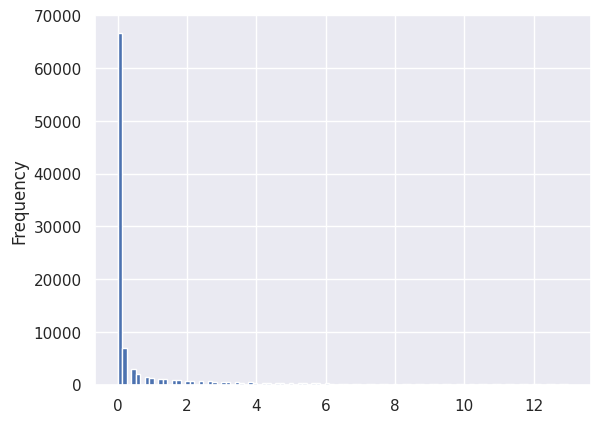

In [ ]:
X_train_2["Rainfall"].plot(kind='hist', bins = 100)

In [ ]:
search_cv2 = GridSearchCV(clf, param_grid, scoring= 'recall')
search_cv2.fit(X_train_2, y_train_2)
print("Best params:")
print(search_cv2.best_params_)

Best params:
{'classifier__C': 10, 'preprocessor__cat__selector__percentile': 10, 'preprocessor__num__imputer__strategy': 'median'}


In [ ]:
y_pred = search_cv2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91     31059
           1       0.44      0.74      0.55      4490

    accuracy                           0.85     35549
   macro avg       0.70      0.80      0.73     35549
weighted avg       0.89      0.85      0.86     35549



Значительного улучшения модели не произошло

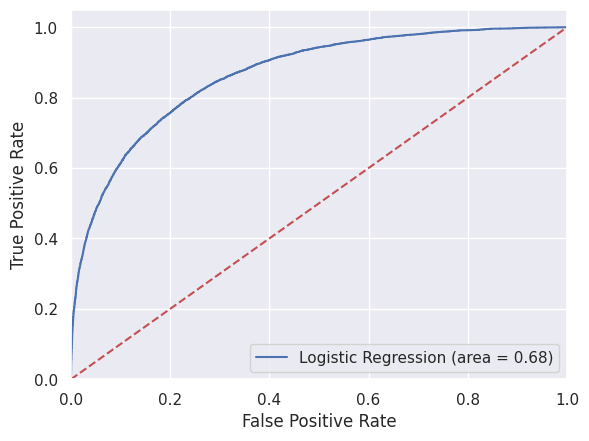

In [ ]:

logit_roc_auc = roc_auc_score(y_test, search_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, search_cv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

В результате можно сказать, что после всех проделанных операций recall все еще остался ниже 0.8. Предсказание дождя оказалось сложной задачей

# Метод ближайших соседей

Только численные признаки

In [ ]:

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     30319
           1       0.45      0.66      0.54      5230

    accuracy                           0.83     35549
   macro avg       0.70      0.76      0.72     35549
weighted avg       0.87      0.83      0.85     35549



Несколько категориальных. Добавлять много категориальных признаков не стоит, т.к. метод ближайших соседей чувствителен к размерности

In [ ]:

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]
)

categorical_features = ['RainToday','WindGustDir']
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),

    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = 7))]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.95      0.86      0.90     30633
           1       0.44      0.69      0.54      4916

    accuracy                           0.84     35549
   macro avg       0.69      0.78      0.72     35549
weighted avg       0.88      0.84      0.85     35549



In [ ]:
%%timeit
y_test_pred = clf.predict(X_test)

22.6 s ± 723 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
param_grid = {
    "classifier__n_neighbors": list(range(1,10,2)),
    "classifier__p": [0.5,1,2]
}

search_cv = GridSearchCV(clf, param_grid)
search_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp3pm'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['RainToday',
                                                                          'WindGustDir'])])),
                                       ('classifier',
                                        KNeighborsClassifier(n_neighbors=7))]),
             param_grid={'classifier__n_neighbors': [1, 3, 5, 7, 9],
                         'classifier__p': [0.5, 1, 2]})

In [ ]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'classifier__n_neighbors': 9, 'classifier__p': 1}


In [ ]:
y_pred = search_cv.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     30890
           1       0.43      0.70      0.53      4659

    accuracy                           0.84     35549
   macro avg       0.69      0.78      0.72     35549
weighted avg       0.88      0.84      0.85     35549



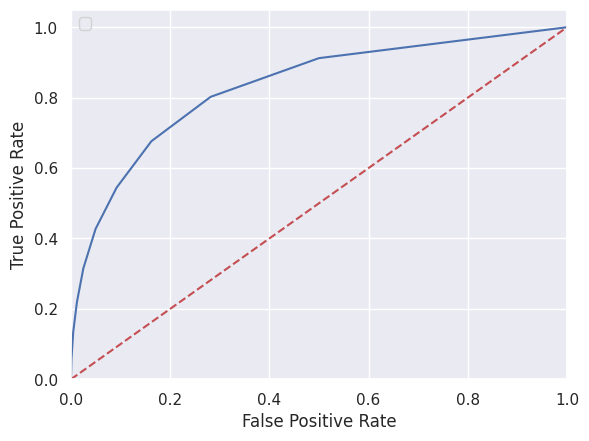

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, search_cv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Наивный Байес

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GaussianNB())]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     30138
           1       0.48      0.67      0.56      5411

    accuracy                           0.84     35549
   macro avg       0.71      0.77      0.73     35549
weighted avg       0.87      0.84      0.85     35549



In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean"))]
)

categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
categorical_features.remove('Location')
X_train[categorical_features] = X_train[categorical_features].fillna("NotGiven")
X_test[categorical_features] = X_test[categorical_features].fillna("NotGiven")

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        #("selector", SelectPercentile(chi2, percentile=90)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_2),
        #("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GaussianNB(var_smoothing=1))]
)

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print('На тесте\n', classification_report(y_test_pred, y_test))

На тесте
               precision    recall  f1-score   support

           0       1.00      0.79      0.88     35126
           1       0.05      0.92      0.10       423

    accuracy                           0.79     35549
   macro avg       0.52      0.86      0.49     35549
weighted avg       0.99      0.79      0.87     35549



In [ ]:
%%timeit
clf.fit(X_train, y_train)

67.8 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


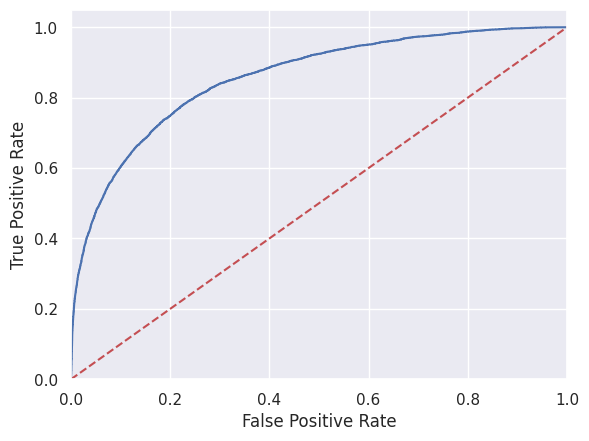

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Логистическая регрессия, реализованная самостоятельно

Сначала проверка работы

In [ ]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [ ]:
def probability(theta, X):
    result = 1/(1+np.exp(-np.dot(X,theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

In [ ]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = prob > threshold
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

In [ ]:
def logloss(theta, X, y):
    result = -np.mean(y*np.log(probability(theta, X))+(1-y)*np.log(probability(-theta, X)))
    return result

assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

In [ ]:
def gradient(theta, X, y):
    result = np.dot(X.T, probability(theta, X) - y) / y.size
    return result

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

In [ ]:
import time
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)

    errors = []

    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]

    # plt
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')


    for _ in range(iters):

        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)

        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'


        # Обновляем веса

        theta -= grad * h

        theta_history = np.vstack((theta_history, theta))

        # error
        loss = logloss(theta, X, y)
        errors.append(loss)

        if plot:
            ax1.clear()
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')


            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')

            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()

    return theta

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=2000)

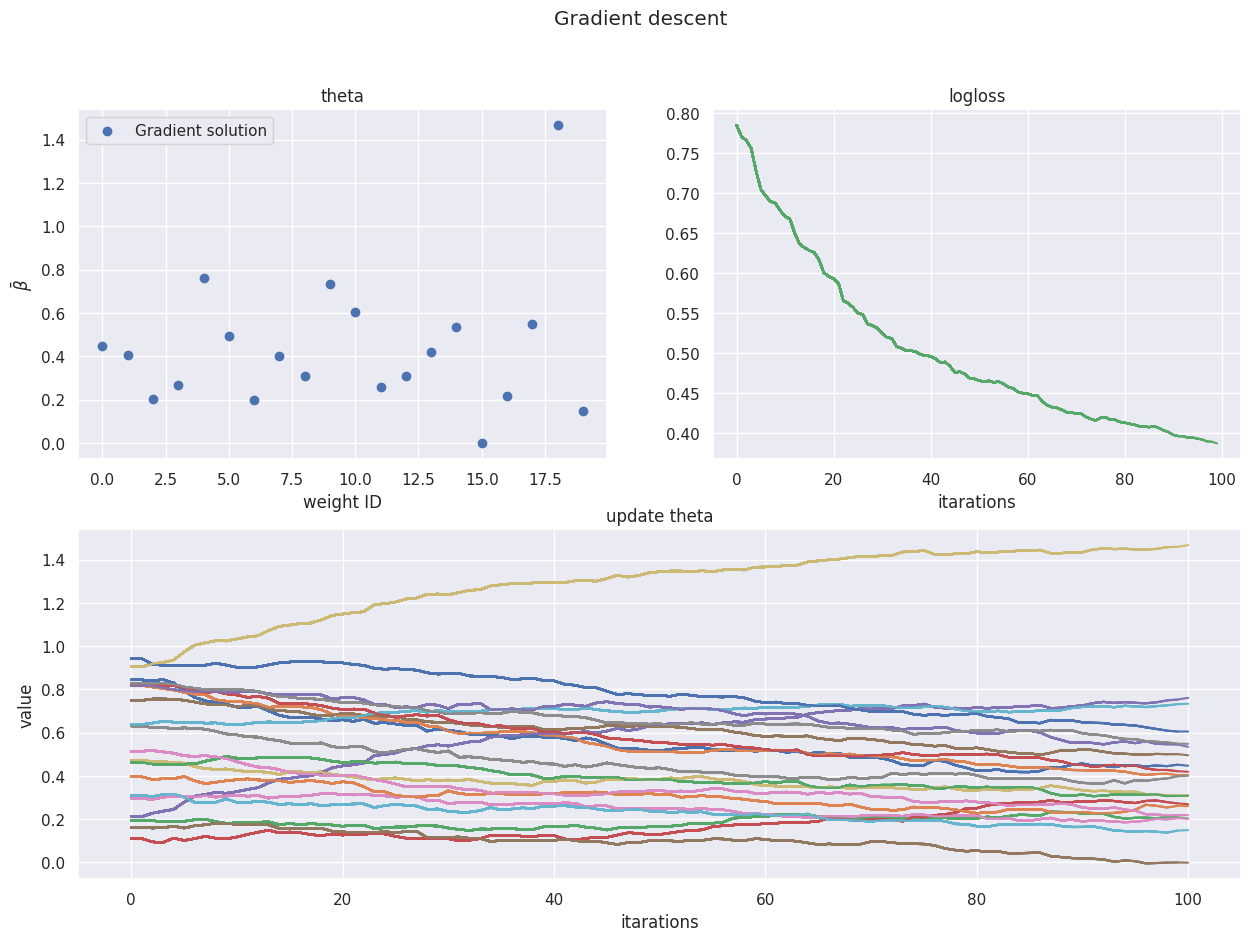

In [ ]:
optimal_theta = fit(X, y)

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X)

In [ ]:
print(classification_report(y_pred, y))

              precision    recall  f1-score   support

       False       0.79      0.89      0.84       882
        True       0.91      0.81      0.86      1118

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [ ]:

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

numeric_features = ['Cloud3pm','Sunshine','Pressure3pm','WindGustSpeed','Temp3pm','Rainfall']
categorical_features = ['RainToday' ]

transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

transformed = transformer.fit_transform(data)
transformed_df = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())

y = data['RainTomorrow']
X = transformed_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle = False)

X_train_val = X_train.values
X_test_val = X_test.values
y_train_val = y_train.astype(int).values
y_test_val = y_test.astype(int).values

In [ ]:
X.columns

Index(['num__Cloud3pm', 'num__Sunshine', 'num__Pressure3pm',
       'num__WindGustSpeed', 'num__Temp3pm', 'num__Rainfall',
       'cat__RainToday_No', 'cat__RainToday_Yes', 'cat__RainToday_nan'],
      dtype='object')

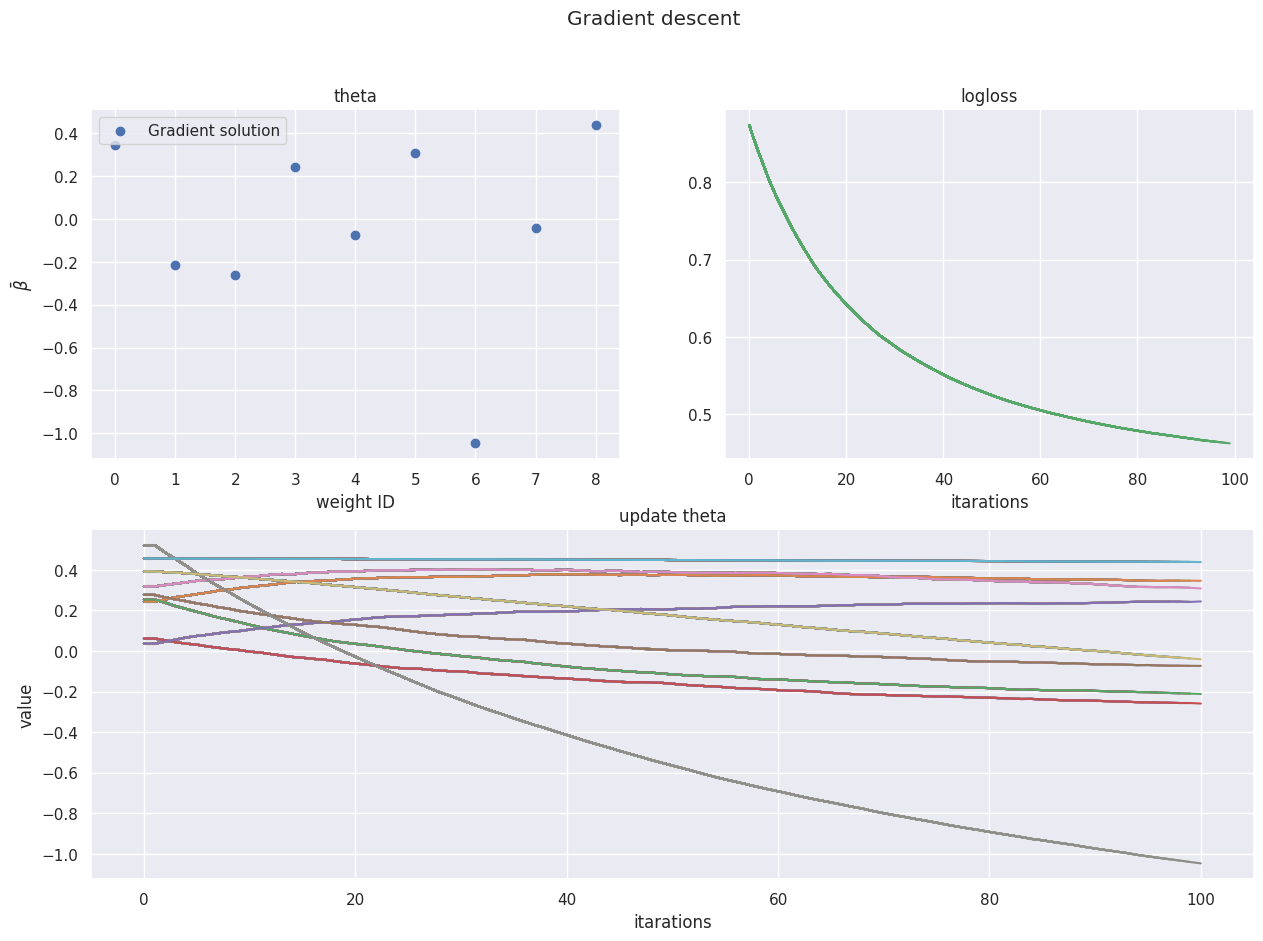

In [ ]:
optimal_theta = fit(X_train_val , y_train_val, iters = 100, batch_size=1000, h=0.1)

In [ ]:

score = []
thresholds = np.linspace(0.0,1.0,100)
for threshold in thresholds:
  y_pred = binary_class_prediction(optimal_theta, X_test_val , threshold = threshold)
  score.append(f1_score(y_test_val, y_pred))
thresholds[np.argmax(score)],np.max(score)

(0.3535353535353536, 0.5779345734445157)

In [ ]:
y_pred = binary_class_prediction(optimal_theta, X_test_val , threshold = thresholds[np.argmax(score)])
print('На тесте\n', classification_report(y_pred, y_test_val))

На тесте
               precision    recall  f1-score   support

       False       0.80      0.91      0.85     24508
        True       0.71      0.49      0.58     11041

    accuracy                           0.78     35549
   macro avg       0.75      0.70      0.71     35549
weighted avg       0.77      0.78      0.77     35549



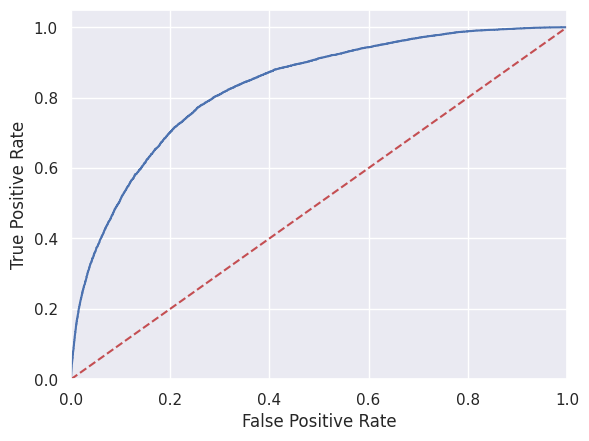

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probability(optimal_theta, X_test))
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Выводы

Получить надежную модель для предсказания дождя оказалось достаточно сложной задачей. Наиболее значимыми признаками оказались RainToday, Cloud3pm, Sunshine, Pressure3pm. Время работы у метода ближайших соседей оказалось самым большим. Самое маленькое время работы у наивного байесовского подхода. Если смотреть на метрику recall, то лучше всех получилось настроить модель наивного байеса, однако она дает меньший accuracy и f1-score. Лучший f1-score показала модель логистической регрессии с использованием sklearn. На реализованной самостоятельно логистической регрессии не удалось достичь аналогичного f1-score, к тому же функция работает значительно дольше. Если отдавать предпочтение какой-то одной модели, то я бы выбрал модель логистической регрессии, поскольку она дает лучшие результаты по качеству.